### Protein Grouping based on AlphaDIA output

Start from psm.tsv output & implement protein grouping:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Use the index of psm_table as peptide IDs for easier lookup; otherwise, the unique identifier for a precursor is the precursor_idx. Generate a dataframe `protein_table` with a `proteins` and  `peptides` column, where the latter contains sets of all peptides belonging to a certain protein. Generate a lookup list containing all peptide indices, and a boolean state vector of the same length to indicate whether this peptide has been taken by a protein. 

- 1.: Identify proteotypic precursors --> this has an issue for now, proteins apparently only contains protein ambiguity groups (e.g. isoforms)
- 2.: Merge all proteins in `protein_table` if their peptides are identical.
- 3.: Merge all proteins in `protein_table` into ambiguity groups if their peptides are subsets of each other
- 4.: Use greedy set cover to assign peptides to proteins by the razor principle & maximum parsimony

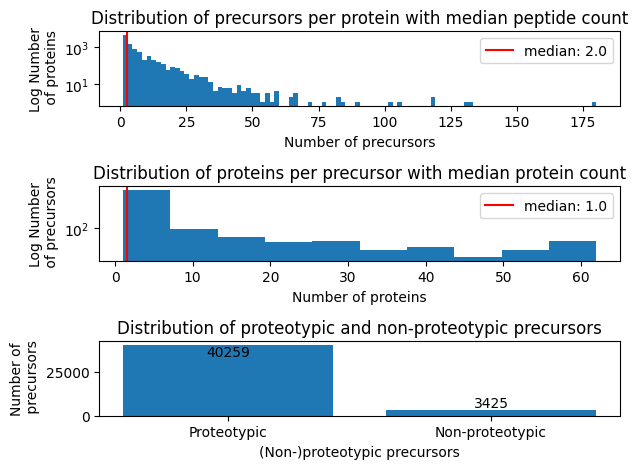

In [3]:
#retrieve psm.tsv output table
precursor_table = pd.read_csv("./../../../../data/alphadia_example_output/psm.tsv", sep = "\t")

#Generate dataframe where each row is a protein and the peptides are in a set
protein_table = precursor_table.groupby("proteins").apply(lambda x : set(x.index)).reset_index(name = "peptides")
protein_table.sort_values(by = "peptides", key = lambda x : x.str.len(), ascending = False, inplace = True)

#Convert csv protein names to set
precursor_table["proteins_set"] = precursor_table.proteins.apply(lambda x : set(x.split(";")))
precursor_table.sort_values(by = "proteins_set", key = lambda x : x.str.len(), ascending = False, inplace = True)

#Add proteotypicity column
precursor_table["proteotypic"] = precursor_table.proteins_set.apply(lambda x : len(x) == 1)

#visualize distribution of peptide counts per protein and proteins per peptide
fig, ax = plt.subplots(3, 1)
ax[0].hist(protein_table.peptides.str.len(), bins = 100, log = True)
ax[0].set_xlabel("Number of precursors")
ax[0].set_ylabel("Log Number\n of proteins")
ax[0].axvline(protein_table.peptides.str.len().median() + 0.5, color = "red", label = f"median: {protein_table.peptides.str.len().median()}")
ax[0].set_title("Distribution of precursors per protein with median peptide count")
ax[0].legend()
ax[1].hist(precursor_table.proteins_set.str.len(), bins = 10, log = True)
ax[1].set_xlabel("Number of proteins")
ax[1].set_ylabel("Log Number\n of precursors")
ax[1].axvline(precursor_table.proteins_set.str.len().median() + 0.5, color = "red", label = f"median: {precursor_table.proteins_set.str.len().median()}")
ax[1].set_title("Distribution of proteins per precursor with median protein count")
ax[1].legend()
ax[2].bar(["Proteotypic", "Non-proteotypic"], [precursor_table.proteotypic.sum(), np.abs((~precursor_table.proteotypic).sum())], log = False)
ax[2].set_title("Distribution of proteotypic and non-proteotypic precursors")
#label bars with counts
for i, v in enumerate([precursor_table.proteotypic.sum(), np.abs((~precursor_table.proteotypic).sum())]):
    alignment = ["top" if v > precursor_table.proteotypic.sum()/2 else "bottom"][0]
    ax[2].text(i, v, str(v), ha = "center", va = alignment)
ax[2].set_xlabel("(Non-)proteotypic precursors")
ax[2].set_ylabel("Number of\n precursors")
fig.tight_layout()

plt.show()

In [19]:
#rewrite group_proteins: this function should intake a list of precursor indices and a list of semicolon-separated ID-strings 
def group_and_parsimony(
        precursor_idx: np.array,
        precursor_ids: np.array
):
    """
    Function to group ids based on precursor indices and return groups & master ids as lists
    
    Paramters:
        precursor_idx (list): list containing unique integer indices corresponding to each peptide precursor
        precursor_ids (list): list of semicolon separated ids belonging to a given peptide precursor
    
    Returns:
        ids (list): list of ids linked to a given peptide precursor, such that each precursor only belongs to one id. This list is ordered by precursor_idx.
        groups (list): list of semicolon separated ids belonging to a given peptide precursor, such that each precursor only belongs to one group. This list is ordered by precursor_idx.
    
    """

    #reshape precursor indices and ids into a dictionary of ids linked to sets of precursors
    id_dict = {}
    for precursor, ids in zip(precursor_idx, precursor_ids):
        for id in ids.split(";"):
            if id not in id_dict:
                id_dict[id] = set()
            id_dict[id].add(precursor)
    
    #perform greedy set cover on protein_dict: if two ids share a precursor, the precorsor is deleted from the id with fewer precursors. If this removes all precursors from an id, it is added to the larger id's group.
    id_dict = dict(sorted(id_dict.items(), key = lambda x : len(x[1]), reverse = True))
    id_group = []
    id_master = []
    precursor_set = []

    #loop bounds max iterations
    for _ in range(len(id_dict)):
        query_id = list(id_dict.keys())[0]
        query_peptides = id_dict.pop(query_id)
        query_group = [query_id]
        if len(query_peptides) == 0:
            break

        #update peptides & add to group if depleted
        for subject_protein, subject_peptides in id_dict.items():
            if len(subject_peptides) == 0:
                continue
            new_subject_set = subject_peptides - query_peptides
            id_dict[subject_protein] = new_subject_set 
            if len(new_subject_set) == 0:
                query_group.append(subject_protein)

        #save query to output lists
        id_group.append(query_group)
        id_master.append(query_id)
        precursor_set.append(query_peptides)

        #resort before next iteration
        id_dict = dict(sorted(id_dict.items(), key = lambda x : len(x[1]), reverse = True))

    #convert id_group sublists to semicolon separated strings
    id_group = [";".join(x) for x in id_group]

    #reshape output data and align with precursor dataframe input. Use dictionary for efficient ordering
    return_dict = {}
    for i, peptide_set in enumerate(precursor_set):
        for key in peptide_set:
            return_dict[key] = (id_master[i], id_group[i])

    #check that all precursors are found again
    assert len(return_dict) == len(precursor_idx)

    #order by precursor index
    return_dict_ordered = {key: return_dict[key] for key in precursor_idx}
    ids, groups = zip(*return_dict_ordered.values())

    return ids, groups

#outermost function
def perform_grouping(
        psm: pd.DataFrame,
        genes_or_proteins = "proteins",
):
    """Highest level function for grouping proteins in precursor table

    Parameters:
        gene_or_protein (str, optional): Column to group proteins by. Defaults to "proteins".
    
    """

    if genes_or_proteins not in ["genes", "proteins"]:
        raise ValueError("Selected column must be 'genes' or 'proteins'")

    #create non-duplicated view of precursor table
    duplicate_mask = ~psm.duplicated(subset = ["precursor_idx", genes_or_proteins], keep = "first")
    upsm = psm.loc[duplicate_mask, ["precursor_idx", genes_or_proteins, "_decoy"]]
        
    #handle case with only one decoy class:
    unique_decoys = upsm["_decoy"].unique()
    if len(unique_decoys) == 1:
        upsm["_decoy"] = -1
        upsm[str("parsimony_" + genes_or_proteins)], upsm[str("parsimony_" + genes_or_proteins + "_groups")] = group_and_parsimony(upsm.precursor_idx.values, upsm[genes_or_proteins].values) 
        upsm = upsm[["precursor_idx", str("parsimony_" + genes_or_proteins), str("parsimony_" + genes_or_proteins + "_groups")]]
    else:
        target_mask = upsm["_decoy"] == 0
        decoy_mask = upsm["_decoy"] == 1

        t_df = upsm[target_mask].copy()
        new_columns = group_and_parsimony(t_df.precursor_idx.values, t_df[genes_or_proteins].values) 
        t_df[str("parsimony_" + genes_or_proteins)], t_df[str("parsimony_" + genes_or_proteins + "_groups")] = new_columns
        
        d_df = upsm[decoy_mask].copy()
        new_columns = group_and_parsimony(d_df.precursor_idx.values, d_df[genes_or_proteins].values) 
        d_df[str("parsimony_" + genes_or_proteins)], d_df[str("parsimony_" + genes_or_proteins + "_groups")] = new_columns
        
        upsm = pd.concat([t_df, d_df])[["precursor_idx", str("parsimony_" + genes_or_proteins), str("parsimony_" + genes_or_proteins + "_groups")]]

    return psm.merge(upsm, on = "precursor_idx", how = "left")

In [20]:
#test with sample data
precursor_idx = [0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
proteins = ['P1;P2;P3;P4', 'P1;P2;P3;P4', 'P1;P2', 'P1;P2', 'P4', 'P4', 'P4;P5', 'P4;P5', 'P6', 'P6']
decoy = [0,0,0,0,0,1,1,1,1,1]
df = pd.DataFrame({
    "precursor_idx": precursor_idx,
    "proteins": proteins,
    "_decoy": decoy
})
x = perform_grouping(df)
x

,precursor_idx,proteins,_decoy,parsimony_proteins,parsimony_proteins_groups
0,0,P1;P2;P3;P4,0,P1,P1;P2;P3
1,0,P1;P2;P3;P4,0,P1,P1;P2;P3
2,1,P1;P2,0,P1,P1;P2;P3
3,1,P1;P2,0,P1,P1;P2;P3
4,2,P4,0,P4,P4
5,2,P4,1,P4,P4
6,3,P4;P5,1,P4,P4;P5
7,3,P4;P5,1,P4,P4;P5
8,4,P6,1,P6,P6
9,4,P6,1,P6,P6


In [22]:
#test with alphadia data
import pandas as pd
psm = pd.read_csv("./../../../../data/alphadia_example_output/psm.tsv", sep = "\t")
psm = perform_grouping(psm)
display(psm.head())

,base_width_mobility,base_width_rt,rt_observed,mobility_observed,mono_ms1_intensity,top_ms1_intensity,sum_ms1_intensity,weighted_ms1_intensity,weighted_mass_deviation,weighted_mass_error,...,flat_frag_start_idx,channel,i_2,mz_library,_decoy,proba,qval,run,parsimony_proteins,parsimony_proteins_groups
0,0.0,61.264650,4150.9365,0.000001,168609580.0,168609580.0,414403260.0,128811016.0,-0.059417,0.059417,...,355530,0,0.194793,946.43380,0.0,0.000028,0.0,HF_20210523_M300-Y700_DIA_3,P16521,P16521;P53978
1,0.0,39.634766,3776.8835,0.000001,27051602.0,26593468.0,70354530.0,20971468.0,-0.171322,0.171322,...,498472,0,0.210362,1094.04240,0.0,0.000030,0.0,HF_20210523_M300-Y700_DIA_3,P38011,P38011
2,0.0,36.285156,4728.6430,0.000001,37786816.0,37786816.0,91618260.0,28982200.0,-0.038115,0.038115,...,470025,0,0.188118,900.42770,0.0,0.000031,0.0,HF_20210523_M300-Y700_DIA_3,P33331,P33331
3,0.0,61.782715,5049.4670,0.000001,152851000.0,171884340.0,429470700.0,126024584.0,-0.080193,0.080193,...,339007,0,0.213075,1018.02515,0.0,0.000033,0.0,HF_20210523_M300-Y700_DIA_3,P14540,P14540
4,0.0,40.335450,3715.7993,0.000001,52148544.0,52148544.0,135551440.0,40438244.0,-0.192274,0.192274,...,278590,0,0.200084,931.41960,0.0,0.000049,0.0,HF_20210523_M300-Y700_DIA_3,P05759,P05759;P0CG63;P0CH08;P0CH09


Generate exhaustive edge cases: Nesvizhskii, Alexey I., and Ruedi Aebersold. "Interpretation of shotgun proteomic data." Molecular & cellular proteomics 4.10 (2005): 1419-1440. Figure 5:





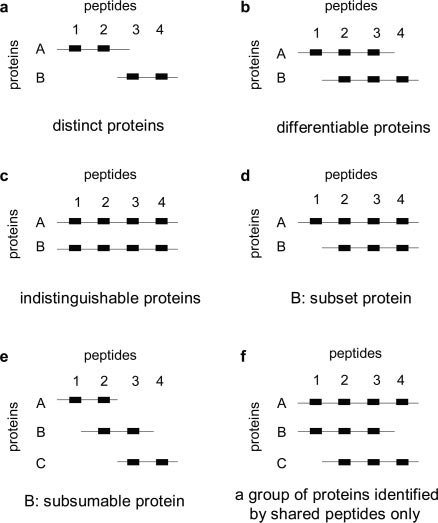

In [23]:
#test cases per Nesvizhskii, Alexey I., and Ruedi Aebersold. "Interpretation of shotgun proteomic data." Molecular & cellular proteomics 4.10 (2005): 1419-1440. Figure 5 (see Appendix)
def test_grouping():

    #1. distinct proteins: both proteins are reported
    distinct_proteins = pd.DataFrame({"precursor_idx": [1,2,3,4], "proteins": ["A", "A", "B", "B"], "_decoy": [0,0,0,0]})
    print("distinct proteins")
    display(distinct_proteins)
    display(perform_grouping(distinct_proteins, genes_or_proteins = "proteins"))
    assert perform_grouping(distinct_proteins, genes_or_proteins = "proteins").to_dict(orient = 'list') == {"precursor_idx":[1,2,3,4], "proteins":["A","A","B","B"], "_decoy":[0,0,0,0], "parsimony_proteins":["A","A","B","B"], "parsimony_proteins_groups":["A","A","B","B"]}

    #2. differentiable proteins: shared peptides go to one protein
    differentiable_proteins = pd.DataFrame({"precursor_idx": [1,2,3,4], "proteins": ["A", "A;B", "A;B", "B"], "_decoy": [0,0,0,0]})
    print("differentiable proteins")
    display(differentiable_proteins)
    display(perform_grouping(differentiable_proteins, genes_or_proteins = "proteins"))
    assert perform_grouping(differentiable_proteins, genes_or_proteins = "proteins").to_dict(orient = 'list') == {"precursor_idx":[1,2,3,4], "proteins":["A", "A;B", "A;B", "B"], "_decoy":[0,0,0,0], "parsimony_proteins":["A","A","A","B"], "parsimony_proteins_groups":["A","A","A","B"]}

    #3. indistinguishable proteins: one is totally removed
    indistinguishable_proteins = pd.DataFrame({"precursor_idx": [1,2,3,4], "proteins": ["A;B", "A;B", "A;B", "A;B"], "_decoy": [0,0,0,0]})
    print("indistinguishable proteins")
    display(indistinguishable_proteins)
    display(perform_grouping(indistinguishable_proteins, genes_or_proteins = "proteins"))
    assert perform_grouping(indistinguishable_proteins, genes_or_proteins = "proteins").to_dict(orient = 'list') == {"precursor_idx":[1,2,3,4], "proteins":["A;B", "A;B", "A;B", "A;B"], "_decoy":[0,0,0,0], "parsimony_proteins":["A","A","A","A"], "parsimony_proteins_groups":["A;B","A;B","A;B","A;B"]}
    
    #4. subset protein: subsetted protein is removed
    subset_proteins = pd.DataFrame({"precursor_idx": [1,2,3,4], "proteins": ["A", "A;B", "A;B", "A;B"], "_decoy": [0,0,0,0]})
    print("subset proteins")
    display(subset_proteins)
    display(perform_grouping(subset_proteins, genes_or_proteins = "proteins"))
    assert perform_grouping(subset_proteins, genes_or_proteins = "proteins").to_dict(orient = 'list') == {"precursor_idx":[1,2,3,4], "proteins":["A", "A;B", "A;B", "A;B"], "_decoy":[0,0,0,0], "parsimony_proteins":["A","A","A","A"], "parsimony_proteins_groups":["A;B","A;B","A;B","A;B"]}

    #5. subsumable proteins --> there are two possible outcomes depending on whether one starts with the middle or either end of the chain
    subsumable_proteins = pd.DataFrame({"precursor_idx": [1,2,3,4], "proteins": ["A", "A;B", "B;C", "C"], "_decoy": [0,0,0,0]})
    print("subsumable proteins")
    display(subsumable_proteins)
    display(perform_grouping(subsumable_proteins, genes_or_proteins = "proteins"))
    assert perform_grouping(subsumable_proteins, genes_or_proteins = "proteins").to_dict(orient = 'list') == {"precursor_idx":[1,2,3,4], "proteins":["A", "A;B", "B;C", "C"], "_decoy":[0,0,0,0], "parsimony_proteins":["A","A","C","C"], "parsimony_proteins_groups":["A","A","C;B","C;B"]}

    #6. a group of proteins identified by shared peptides only
    shared_only = pd.DataFrame({"precursor_idx": [1,2,3,4], "proteins": ["A;B", "A;B;C", "A;B;C", "A;C"], "_decoy": [0,0,0,0]})
    print("shared only")
    display(shared_only)
    display(perform_grouping(shared_only, genes_or_proteins = "proteins"))
    assert perform_grouping(shared_only, genes_or_proteins = "proteins").to_dict(orient = 'list') == {"precursor_idx":[1,2,3,4], "proteins":["A;B", "A;B;C", "A;B;C", "A;C"], "_decoy":[0,0,0,0], "parsimony_proteins":["A","A","A","A"], "parsimony_proteins_groups":["A;B;C","A;B;C","A;B;C","A;B;C"]}

    #7. circular proteins
    circular = pd.DataFrame({"precursor_idx": [1,2,3,4], "proteins": ["A;B;C", "B;C;D", "C;D;E", "D;E;A"], "_decoy": [0,0,0,0]})
    print("circular")
    display(circular)
    display(perform_grouping(circular, genes_or_proteins = "proteins"))
    assert perform_grouping(circular, genes_or_proteins = "proteins").to_dict(orient = 'list') == {"precursor_idx":[1,2,3,4], "proteins":["A;B;C", "B;C;D", "C;D;E", "D;E;A"], "_decoy":[0,0,0,0], "parsimony_proteins":["C","C","C","D"], "parsimony_proteins_groups":["C;B", "C;B", "C;B", "D;A;E"]}

    #8. Complex example --> depending on which of the equivalent proteins P1 and P4 is chosen first, the grouping will be different
    complex_example = pd.DataFrame({"precursor_idx": [0,1,2,3], "proteins": ["P1;P2;P3;P4", "P1;P4", "P2", "P2;P5"], "_decoy": [0,0,0,0]})
    print("complex example")
    display(complex_example)
    display(perform_grouping(complex_example, genes_or_proteins = "proteins"))
    assert perform_grouping(complex_example, genes_or_proteins = "proteins").to_dict(orient = 'list') == {"precursor_idx":[0,1,2,3], "proteins":["P1;P2;P3;P4", "P1;P4", "P2", "P2;P5"], "_decoy":[0,0,0,0], "parsimony_proteins":["P2", "P1", "P2", "P2"], "parsimony_proteins_groups":["P2;P3;P5","P1;P4","P2;P3;P5","P2;P3;P5"]}

test_grouping()

distinct proteins


,precursor_idx,proteins,_decoy
0,1,A,0
1,2,A,0
2,3,B,0
3,4,B,0


,precursor_idx,proteins,_decoy,parsimony_proteins,parsimony_proteins_groups
0,1,A,0,A,A
1,2,A,0,A,A
2,3,B,0,B,B
3,4,B,0,B,B


differentiable proteins


,precursor_idx,proteins,_decoy
0,1,A,0
1,2,A;B,0
2,3,A;B,0
3,4,B,0


,precursor_idx,proteins,_decoy,parsimony_proteins,parsimony_proteins_groups
0,1,A,0,A,A
1,2,A;B,0,A,A
2,3,A;B,0,A,A
3,4,B,0,B,B


indistinguishable proteins


,precursor_idx,proteins,_decoy
0,1,A;B,0
1,2,A;B,0
2,3,A;B,0
3,4,A;B,0


,precursor_idx,proteins,_decoy,parsimony_proteins,parsimony_proteins_groups
0,1,A;B,0,A,A;B
1,2,A;B,0,A,A;B
2,3,A;B,0,A,A;B
3,4,A;B,0,A,A;B


subset proteins


,precursor_idx,proteins,_decoy
0,1,A,0
1,2,A;B,0
2,3,A;B,0
3,4,A;B,0


,precursor_idx,proteins,_decoy,parsimony_proteins,parsimony_proteins_groups
0,1,A,0,A,A;B
1,2,A;B,0,A,A;B
2,3,A;B,0,A,A;B
3,4,A;B,0,A,A;B


subsumable proteins


,precursor_idx,proteins,_decoy
0,1,A,0
1,2,A;B,0
2,3,B;C,0
3,4,C,0


,precursor_idx,proteins,_decoy,parsimony_proteins,parsimony_proteins_groups
0,1,A,0,A,A
1,2,A;B,0,A,A
2,3,B;C,0,C,C;B
3,4,C,0,C,C;B


shared only


,precursor_idx,proteins,_decoy
0,1,A;B,0
1,2,A;B;C,0
2,3,A;B;C,0
3,4,A;C,0


,precursor_idx,proteins,_decoy,parsimony_proteins,parsimony_proteins_groups
0,1,A;B,0,A,A;B;C
1,2,A;B;C,0,A,A;B;C
2,3,A;B;C,0,A,A;B;C
3,4,A;C,0,A,A;B;C


circular


,precursor_idx,proteins,_decoy
0,1,A;B;C,0
1,2,B;C;D,0
2,3,C;D;E,0
3,4,D;E;A,0


,precursor_idx,proteins,_decoy,parsimony_proteins,parsimony_proteins_groups
0,1,A;B;C,0,C,C;B
1,2,B;C;D,0,C,C;B
2,3,C;D;E,0,C,C;B
3,4,D;E;A,0,D,D;A;E


complex example


,precursor_idx,proteins,_decoy
0,0,P1;P2;P3;P4,0
1,1,P1;P4,0
2,2,P2,0
3,3,P2;P5,0


,precursor_idx,proteins,_decoy,parsimony_proteins,parsimony_proteins_groups
0,0,P1;P2;P3;P4,0,P2,P2;P3;P5
1,1,P1;P4,0,P1,P1;P4
2,2,P2,0,P2,P2;P3;P5
3,3,P2;P5,0,P2,P2;P3;P5


# Appendix:

In [152]:
#develop inner functions that are ultimately summarized into group_and_parsimony
#inner conversion function to convert input dataframe columns to dict for grouping
def group_ids(
        precursor_list: list,
        id_list: list
):
    """
    Function to reshape list of strings containing semicolon-separated IDs into a dict of sets, where each key is an ID and each value is a set of precursor indices.
    
    Parameters:
        precursors (list): List of int containing precursor indices.
        ids (list): List of str containing semicolon-separated IDs.

    Returns:
        dict of sets: Each key is an ID and each value is a set of precursor indices.
    """

    id_dict = {}
    for precursor, ids in zip(precursor_list, id_list):
        for id in ids.split(";"):
            if id not in id_dict:
                id_dict[id] = set()
            id_dict[id].add(precursor)
            
    return(id_dict)

#inner grouping or parsimony function for handling the input dict
def protein_grouping(
        protein_dict: dict,
):
    """Perform Parsimony or grouping of proteins

    transform input dict like this 

    | protein_id | peptides |
    |------------|----------|
    | A          | {1;2}    |
    | B          | {1}      |
    | C          | {2}      |
    | D          | {2;3}    |

    either into a protein list with dropped peptides (open issue: handling pat situation where two equally good proteins compete for one peptide, e.g. peptide 2 in the example above)
    note that here, the proteins without peptides are simply dropped from the quan output table!
    
    | protein_id | peptides | peptides remaining |
    |------------|----------|--------------------|
    | A          | {1;2}    | {1;2}              |
    | D          | {2;3}    | {3}                |
    
    or into protein group list where subset proteins are summarized into groups; same issue as above with pat situations: if the list starts with D, C is folded into one group with D
    everything can claim everything approach would result in C being claimed by D as well; parsimony would be needed to then decide which group gets the razor protein

    | protein_group | peptides        | peptides remaining |
    |---------------|-----------------|--------------------|
    | [A, B, C]     | {1;2}           | {1;2}              |
    | [D]           | {2;3}           | {3}                |

    """

    #iterate over every element of the dictionary and delete all peptides that are already claimed by the larger set
    #initial sort and first key
    protein_dict = dict(sorted(protein_dict.items(), key = lambda x : len(x[1]), reverse = True))

    protein_group = []
    protein_id = []
    peptide_set = []

    #loop bounds max iterations
    for _ in range(len(protein_dict)):
        query_protein = list(protein_dict.keys())[0]
        query_peptides = protein_dict.pop(query_protein)
        query_group = [query_protein]
        if len(query_peptides) == 0:
            break

        #update peptides
        for subject_protein, subject_peptides in protein_dict.items():
            if len(subject_peptides) == 0:
                continue
            new_peptide_set = subject_peptides.difference(query_peptides)
            protein_dict[subject_protein] = new_peptide_set 
            if len(new_peptide_set) == 0:
                query_group.append(subject_protein)

        #save query, resort and get first key
        protein_group.append(query_group)
        protein_id.append(query_protein)
        peptide_set.append(query_peptides)
        protein_dict = dict(sorted(protein_dict.items(), key = lambda x : len(x[1]), reverse = True))
        
    return({"protein_id": protein_id, "peptide_set": peptide_set, "protein_group": protein_group})

#inner function to map the output dict back to the precursor dataframe
def map_dict_to_idx(
        grouped_dict: dict,
        precursor_idx: list,
):
    """
    Function to map protein ids and protein groups back to indices to add back to the precursor dataframe
    
    Parameters:
        grouped_dict (dict): Dict containing protein ids and protein groups.
        precursor_idx (list): List of int containing precursor indices.
    
    Returns:
        protein_id (list): List of str containing protein id belonging to a given precursor
        protein_group (list): List of str containing protein group belonging to a given precursor
    
    """

    #two for loops, but the total number of iterations is the number of precursors
    return_dict = {}
    for i, peptide_set in enumerate(grouped_dict["peptide_set"]):
        for key in peptide_set:
            return_dict[key] = (grouped_dict["protein_id"][i], grouped_dict["protein_group"][i])

    #check that all precursors are found again
    assert len(return_dict) == len(precursor_idx)

    return_dict_ordered = {key: return_dict[key] for key in precursor_idx}
    protein_ids, protein_groups = zip(*return_dict_ordered.values())

    return protein_ids, protein_groups

#rewrite group_proteins: this function should intake a list of precursor indices and a list of semicolon-separated ID-strings 
def group_and_parsimony(
        precursor_idx: np.array,
        precursor_ids: np.array
):
    """
    Function to group ids based on precursor indices and return groups & master ids as lists
    
    Paramters:
        precursor_idx (list): list containing unique integer indices corresponding to each peptide precursor
        precursor_ids (list): list of semicolon separated ids belonging to a given peptide precursor
    
    Returns:
        ids (list): list of ids linked to a given peptide precursor, such that each precursor only belongs to one id. This list is ordered by precursor_idx.
        groups (list): list of semicolon separated ids belonging to a given peptide precursor, such that each precursor only belongs to one group. This list is ordered by precursor_idx.
    
    """

    #reshape precursor indices and ids into a dictionary of ids linked to sets of precursors
    id_dict = {}
    for precursor, ids in zip(precursor_idx, precursor_ids):
        for id in ids.split(";"):
            if id not in id_dict:
                id_dict[id] = set()
            id_dict[id].add(precursor)
    
    #perform greedy set cover on protein_dict: if two ids share a precursor, the precorsor is deleted from the id with fewer precursors. If this removes all precursors from an id, it is added to the larger id's group.
    id_dict = dict(sorted(id_dict.items(), key = lambda x : len(x[1]), reverse = True))

    id_group = []
    id_master = []
    precursor_set = []

    #loop bounds max iterations
    for _ in range(len(id_dict)):
        query_id = list(id_dict.keys())[0]
        query_peptides = id_dict.pop(query_id)
        query_group = [query_id]
        if len(query_peptides) == 0:
            break

        #update peptides
        for subject_protein, subject_peptides in id_dict.items():
            new_peptide_set = subject_peptides.difference(query_peptides)
            id_dict[subject_protein] = new_peptide_set 
            if len(new_peptide_set) == 0:
                query_group.append(subject_protein)

        #save query to output lists
        id_group.append(query_group)
        id_master.append(query_id)
        precursor_set.append(query_peptides)

        #resort before next iteration
        id_dict = dict(sorted(id_dict.items(), key = lambda x : len(x[1]), reverse = True))

    #reshape output data and align with precursor dataframe input. Use dictionary for efficient ordering
    return_dict = {}
    for i, peptide_set in enumerate(precursor_set):
        for key in peptide_set:
            return_dict[key] = (id_master[i], id_group[i])

    #check that all precursors are found again
    assert len(return_dict) == len(precursor_idx)

    #order by precursor index
    return_dict_ordered = {key: return_dict[key] for key in precursor_idx}
    ids, groups = zip(*return_dict_ordered.values())

    return ids, groups

#outermost function
def perform_grouping(
        psm: pd.DataFrame,
        genes_or_proteins = "proteins",
):
    """Highest level function for grouping proteins in precursor table

    Parameters:
        gene_or_protein (str, optional): Column to group proteins by. Defaults to "proteins".
    
    """

    if genes_or_proteins not in ["genes", "proteins"]:
        raise ValueError("Selected column must be 'genes' or 'proteins'")

    #create non-duplicated view of precursor table
    upsm = psm.drop_duplicates(subset = ["precursor_idx"], keep = "first")[['precursor_idx','proteins','_decoy']]
    
    #for parallel execution, split view into target and decoy precursors, copy to avoid SettingWithCopyWarning
    t_df = upsm[upsm['_decoy'] == 0].copy()
    t_df[str("parsimony_" + genes_or_proteins)], t_df[str("parsimony_" + genes_or_proteins + "_groups")] = group_and_parsimony(t_df.precursor_idx.values, t_df[genes_or_proteins].values) 
    
    d_df = upsm[upsm['_decoy'] == 1].copy()
    d_df[str("parsimony_" + genes_or_proteins)], d_df[str("parsimony_" + genes_or_proteins + "_groups")] = group_and_parsimony(d_df.precursor_idx.values, d_df[genes_or_proteins].values) 
    
    #create output dataframe and merge to precursor table
    upsm = pd.concat([t_df, d_df])[["precursor_idx", str("parsimony_" + genes_or_proteins), str("parsimony_" + genes_or_proteins + "_groups")]]

    return psm.merge(upsm, on = "precursor_idx", how = "left")


In [10]:
precursor_idx = [0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
proteins = ['P1;P2;P3;P4', 'P1;P2;P3;P4', 'P1;P2', 'P1;P2', 'P4', 'P4', 'P4;P5', 'P4;P5', 'P6', 'P6']
decoy = [0,0,0,0,0,1,1,1,1,1]

t_df = pd.DataFrame({
    "precursor_idx": precursor_idx,
    "proteins": proteins,
    "_decoy": decoy
})

display(t_df)
display(perform_grouping(t_df))

,precursor_idx,proteins,_decoy
0,0,P1;P2;P3;P4,0
1,0,P1;P2;P3;P4,0
2,1,P1;P2,0
3,1,P1;P2,0
4,2,P4,0
5,2,P4,1
6,3,P4;P5,1
7,3,P4;P5,1
8,4,P6,1
9,4,P6,1


,precursor_idx,proteins,_decoy,parsimony_proteins,parsimony_proteins_groups
0,0,P1;P2;P3;P4,0,P1,"[P1, P2, P3]"
1,0,P1;P2;P3;P4,0,P1,"[P1, P2, P3]"
2,1,P1;P2,0,P1,"[P1, P2, P3]"
3,1,P1;P2,0,P1,"[P1, P2, P3]"
4,2,P4,0,P4,"[P4, P2, P3]"
5,2,P4,1,P4,"[P4, P2, P3]"
6,3,P4;P5,1,P4,"[P4, P5]"
7,3,P4;P5,1,P4,"[P4, P5]"
8,4,P6,1,P6,"[P6, P5]"
9,4,P6,1,P6,"[P6, P5]"


In [ ]:
#test group_and_parsimony with psm.tsv input:
import pandas as pd
psm = pd.read_csv("./../../../../data/alphadia_example_output/psm.tsv", sep = "\t")
psm = perform_grouping(psm)

In [154]:
#generate exhaustive protein group configurations; simulate output from collapsing protein longtable. These examples should be processed with group_proteins() and apply_strict_parsimony().
def test_grouping():

    #1. distinct proteins: both proteins are reported
    distinct_proteins = {"A":set([1,2]), "B":set([3,4])}
    print(protein_grouping(distinct_proteins))
    assert protein_grouping(distinct_proteins) == {'protein_id': ['A', 'B'], 'peptide_set': [{1, 2}, {3, 4}], 'protein_group': [['A'], ['B']]}

    #2. differentiable proteins: shared peptides go to one protein
    differentiable_proteins = {"A":set([1,2,3]), "B":set([2,3,4])}
    print(protein_grouping(differentiable_proteins))
    assert protein_grouping(differentiable_proteins) == {"protein_id": ['A', 'B'], "peptide_set": [{1, 2, 3}, {4}], "protein_group": [['A'], ['B']]}

    #3. indistinguishable proteins: one is totally removed
    indistinguishable_proteins = {"A":set([1,2,3,4]), "B":set([1,2,3,4])}
    print(protein_grouping(indistinguishable_proteins))
    assert protein_grouping(indistinguishable_proteins) == {"protein_id": ['A'], "peptide_set": [{1, 2, 3, 4}], "protein_group": [['A', 'B']]}

    #4. subset protein: subsetted protein is removed
    subset_proteins = {"A":set([1,2,3,4]), "B":set([2,3,4])}
    print(protein_grouping(subset_proteins))
    assert protein_grouping(subset_proteins) == {"protein_id": ['A'], "peptide_set": [{1, 2, 3, 4}], "protein_group": [['A', 'B']]}

    #5. subsumable proteins --> there are two possible outcomes depending on whether one starts with the middle or either end of the chain
    subsumable_proteins = {"A":set([1,2]), "B":set([2,3]), "C":set([3,4])}
    print(protein_grouping(subsumable_proteins))
    try:
        assert protein_grouping(subsumable_proteins) == {"protein_id": ['A', 'C'], "peptide_set": [{1,2}, {3,4}], "protein_group": [['A'], ['C', 'B']]}
    except:
        assert protein_grouping(subsumable_proteins) == {"protein_id": ['B', 'A', 'C'], "peptide_set": [{2,3}, {1}, {4}], "protein_group": [['B'], ['A'], ['C']]}

    #6. a group of proteins identified by shared peptides only
    shared_only_dict = {"A":set([1,2,3,4]), "B":set([1,2,3]), "C":set([2,3,4])}
    print(protein_grouping(shared_only_dict))
    assert protein_grouping(shared_only_dict) == {"protein_id": ['A'], "peptide_set": [{1, 2, 3, 4}], "protein_group": [['A', 'B', 'C']]}

    #7. Complex example --> depending on which of the equivalent proteins P1 and P4 is chosen first, the grouping will be different
    complex_example = {"P1":{0, 1},"P2":{0, 2, 3},"P3":{0},"P4":{0, 1},"P5":{3}}
    print(protein_grouping(complex_example))
    assert protein_grouping(complex_example) == {"protein_id": ["P2", "P1"], "peptide_set": [{0, 2, 3}, {1}], "protein_group": [["P2", "P3", "P5"], ["P1", "P4"]]}

test_grouping()

{'protein_id': ['A', 'B'], 'peptide_set': [{1, 2}, {3, 4}], 'protein_group': [['A'], ['B']]}
{'protein_id': ['A', 'B'], 'peptide_set': [{1, 2, 3}, {4}], 'protein_group': [['A'], ['B']]}
{'protein_id': ['A'], 'peptide_set': [{1, 2, 3, 4}], 'protein_group': [['A', 'B']]}
{'protein_id': ['A'], 'peptide_set': [{1, 2, 3, 4}], 'protein_group': [['A', 'B']]}
{'protein_id': ['A', 'C'], 'peptide_set': [{1, 2}, {3, 4}], 'protein_group': [['A'], ['C', 'B']]}
{'protein_id': ['A'], 'peptide_set': [{1, 2, 3, 4}], 'protein_group': [['A', 'B', 'C']]}
{'protein_id': ['P2', 'P1'], 'peptide_set': [{0, 2, 3}, {1}], 'protein_group': [['P2', 'P3', 'P5'], ['P1', 'P4']]}


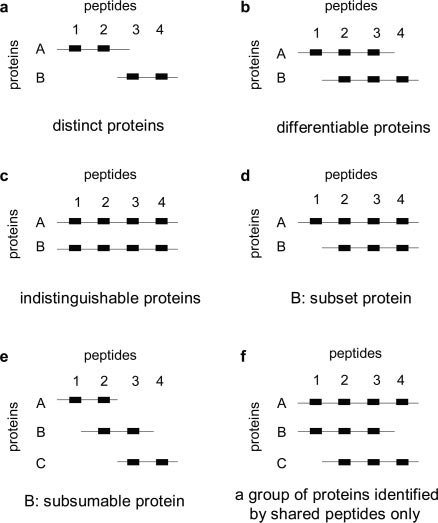